<h1><center>Stock Market Trading Bot</center></h1>

# Importing libraries

In [1]:
! pip install plotly

In [1]:
import csv
import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data Source

[Data Source](https://www.kaggle.com/ghazanfarali/ksedataset?select=UBL.csv) 
[Data Source](https://www.kaggle.com/arsalanjaved/pakistan-stock-exchange)

# Loading data

In [2]:
UBL=pd.read_csv('Data/UBL.csv',index_col='Date',parse_dates=True)
HBL=pd.read_csv('Data/HBL.csv',index_col='Date',parse_dates=True)
NBP=pd.read_csv('Data/NBP.csv',index_col='Date',parse_dates=True)
MEBL=pd.read_csv('Data/MEBL.csv',index_col='Date',parse_dates=True)

UBL.head()

,Symbol,Open,High,Low,Close,Volume
Date,,,,,,
2005-05-26,UBL,61.25,68.00,59.10,59.85,1990000
2005-05-27,UBL,60.00,61.40,58.60,59.40,573700
2005-05-30,UBL,59.00,59.75,56.45,58.40,1026700
2005-05-31,UBL,57.50,58.50,57.10,58.35,684500
2005-06-01,UBL,58.50,61.20,58.15,60.75,1103500


# Plotting Data

Text(0.5, 1.0, 'Trend of Share Price of different KSE-30 Companies')

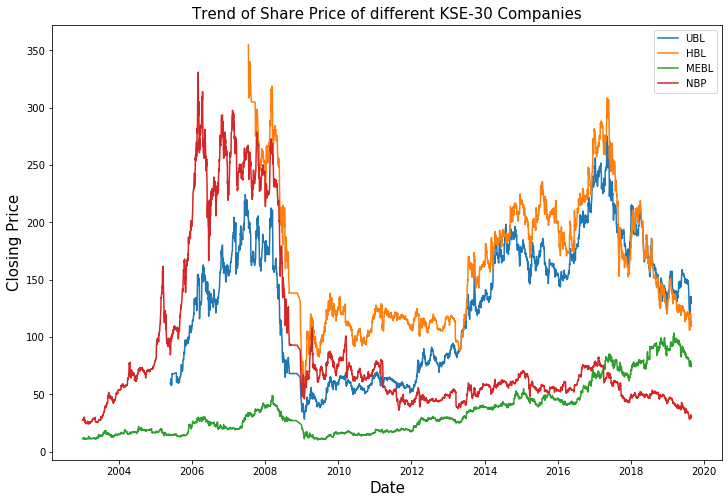

In [3]:
plt.figure(figsize=(12,8))
sns.lineplot(data=UBL.Close,label='UBL')
sns.lineplot(data=HBL.Close,label='HBL')
sns.lineplot(data=MEBL.Close,label='MEBL')
sns.lineplot(data=NBP.Close,label='NBP')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Closing Price',fontsize=15)
plt.title('Trend of Share Price of different KSE-30 Companies',fontsize=15)

# Dropping redundant feature

In [4]:
UBL.drop('Symbol',axis=1,inplace=True)
MEBL.drop('Symbol',axis=1,inplace=True)
NBP.drop('Symbol',axis=1,inplace=True)
HBL.drop('Symbol',axis=1,inplace=True)

# Changing column names in order to facilitate merge

In [5]:
UBL.columns=['UBL_Open','UBL_High','UBL_Low','UBL_Close','UBL_Volume']
MEBL.columns=['MEBL_Open','MEBL_High','MEBL_Low','MEBL_Close','MEBL_Volume']
HBL.columns=['HBL_Open','HBL_High','HBL_Low','HBL_Close','HBL_Volume']


# Merging Data Frame

In [6]:
data=pd.concat([UBL,MEBL,HBL],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4055 entries, 2003-01-01 to 2019-08-30
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UBL_Open     3449 non-null   float64
 1   UBL_High     3449 non-null   float64
 2   UBL_Low      3449 non-null   float64
 3   UBL_Close    3449 non-null   float64
 4   UBL_Volume   3449 non-null   float64
 5   MEBL_Open    3986 non-null   float64
 6   MEBL_High    3986 non-null   float64
 7   MEBL_Low     3986 non-null   float64
 8   MEBL_Close   3986 non-null   float64
 9   MEBL_Volume  3986 non-null   float64
 10  HBL_Open     2948 non-null   float64
 11  HBL_High     2948 non-null   float64
 12  HBL_Low      2948 non-null   float64
 13  HBL_Close    2948 non-null   float64
 14  HBL_Volume   2948 non-null   float64
dtypes: float64(15)
memory usage: 506.9 KB


# Reversing Data Frame

In [7]:
data1=data.iloc[::-1]
data1=data1.reset_index()
data1=data1.iloc[::-1]
data1=data1.set_index('Date')

In [8]:
x=data1

In [9]:
x.head()

,UBL_Open,UBL_High,UBL_Low,UBL_Close,UBL_Volume,MEBL_Open,MEBL_High,MEBL_Low,MEBL_Close,MEBL_Volume,HBL_Open,HBL_High,HBL_Low,HBL_Close,HBL_Volume
Date,,,,,,,,,,,,,,,
2003-01-01,NaN,NaN,NaN,NaN,NaN,11.5,11.60,11.5,11.55,11500.0,NaN,NaN,NaN,NaN,NaN
2003-01-02,NaN,NaN,NaN,NaN,NaN,11.5,11.90,11.5,11.80,16500.0,NaN,NaN,NaN,NaN,NaN
2003-01-03,NaN,NaN,NaN,NaN,NaN,11.7,11.85,11.7,11.85,6500.0,NaN,NaN,NaN,NaN,NaN
2003-01-06,NaN,NaN,NaN,NaN,NaN,11.6,11.85,11.6,11.85,11500.0,NaN,NaN,NaN,NaN,NaN
2003-01-07,NaN,NaN,NaN,NaN,NaN,11.6,11.60,11.6,11.60,5000.0,NaN,NaN,NaN,NaN,NaN


In [11]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime



fig = go.Figure(data=[go.Candlestick(x=x.index,
                open=x['MEBL_Open'],
                high=x['MEBL_High'],
                low=x['MEBL_Low'],
                close=x['MEBL_Close'])])

fig.show()


# Dropping Missing Values

In [12]:
data1.dropna(inplace=True)

In [13]:
data1.isnull().sum().sum()

0

# Basic correlation analysis

In [14]:
data2=data1.loc[:,['UBL_Close','MEBL_Close','HBL_Close']]

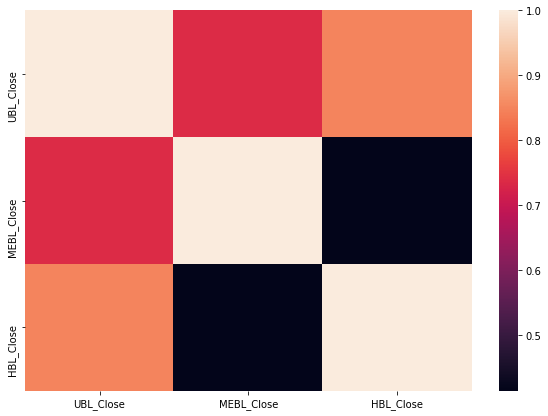

In [15]:
plt.figure(figsize=(10,7))
sns.heatmap(data=data2.corr())

# Pearson Correlation

In [49]:
pearson_coeff,p_val=stats.pearsonr(data2['UBL_Close'],data2['HBL_Close'])
pearson_coeff,p_val

(0.8491742742578102, 0.0)

**_Conclusion:_**

Since the p-value is <
0.001, the correlation between UBL Stock Closing Price and HBL Stock Closing Price is statistically significant, and the linear relationship is quite strong (~0.834).

In [50]:
pearson_coeff,p_val=stats.pearsonr(data2['UBL_Close'],data2['MEBL_Close'])
pearson_coeff,p_val

(0.7386514218064881, 0.0)

**_Conclusion:_**

Since the p-value is <
0.001, the correlation between UBL Stock Closing Price and HBL Stock Closing Price is statistically significant, and the linear relationship is quite strong (~0.738).

In [52]:
pearson_coeff,p_val=stats.pearsonr(data2['MEBL_Close'],data2['HBL_Close'])
pearson_coeff,p_val

(0.41403618176489365, 8.944308697478978e-120)

# Box Plot

Text(0.5, 1.0, 'Trend of Share Price of different KSE-30 Companies')

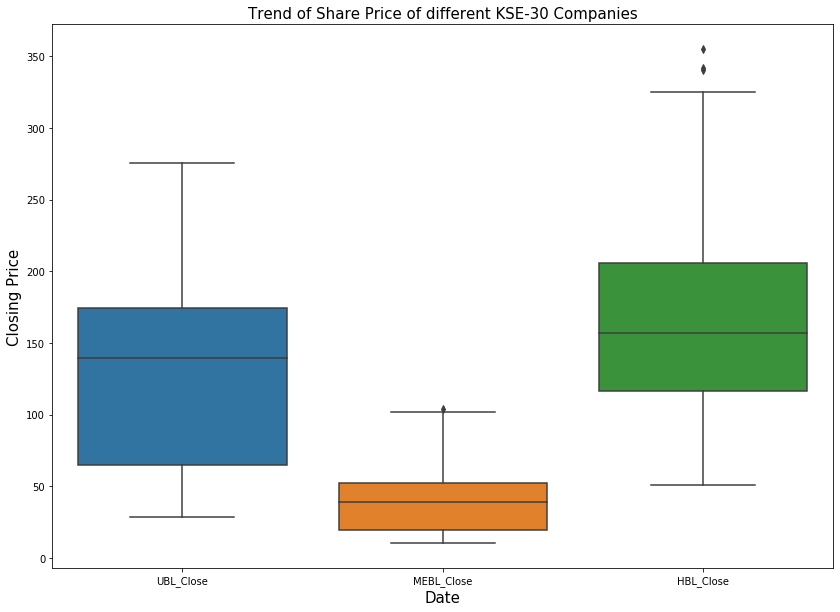

In [16]:
plt.figure(figsize=(14,10))
sns.boxplot(data=data2)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Closing Price',fontsize=15)
plt.title('Trend of Share Price of different KSE-30 Companies',fontsize=15)

# Backend of Trading Framework

In [18]:
def shares_trading(X,nS1,nS2,nS3,share_prices,Prediction,TN,low_thres,high_thres):
    model1_pred,model2_pred,model3_pred=Prediction[0],Prediction[1],Prediction[2]
    pS1,pS2,pS3=(nS1*share_prices[0]),(nS2*share_prices[1]),(nS3*share_prices[2])
    Trade_Occurred,Brocker_fee,Amount_Gained=False,0,0
    if (model1_pred>model2_pred and model1_pred>model3_pred) and (pS1/TN)<high_thres:
        if (model2_pred>model3_pred) and (pS3/TN)>low_thres:
            Amount_Gained=((nS3*share_price[2])*.25)
            Brocker_fee=((nS3*share_price[2])*.25)*.3*.01
            nS3=nS3-(nS3*.25)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=(.997*Amount_Gained)/share_price[0]
            nS1=nS1+Shares_bought
            X=X-(.997*Amount_Gained)
            Trade_Occurred=True
        elif (model3_pred>model2_pred) and (pS2/TN)>low_thres:
            Amount_Gained=((nS2*share_price[1])*.25)
            Brocker_fee=((nS2*share_price[1])*.25)*.3*.01
            nS2=nS2-(nS2*.25)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=(.997*Amount_Gained)/share_price[0]
            nS1=nS1+Shares_bought
            X=X-(.997*Amount_Gained)
            Trade_Occurred=True
        return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee
    
    elif (model2_pred>model1_pred and model2_pred>model3_pred) and (pS2/TN)<high_thres:
        if (model1_pred>model3_pred) and (pS3/TN)>low_thres:
            Amount_Gained=((nS3*share_price[2])*.25)
            Brocker_fee=((nS3*share_price[2])*.25)*.3*.01
            nS3=nS3-(nS3*.25)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=(.997*Amount_Gained)/share_price[1]
            nS2=nS2+Shares_bought
            X=X-(0.997*Amount_Gained)
            Trade_Occurred=True
        elif (model3_pred>model2_pred) and (pS1/TN)>low_thres:
            Amount_Gained=((nS1*share_price[0])*.25)
            Brocker_fee=((nS1*share_price[0])*.25)*.3*.01
            nS1=nS1-(nS1*.25)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=(.997*Amount_Gained)/share_price[1]
            nS2=nS2+Shares_bought
            X=X-(0.997*Amount_Gained)
            Trade_Occurred=True
        elif model1_pred<0 and (pS1/TN)>low_thres:
            
            return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee
    
    elif (model3_pred>model1_pred and model3_pred>model2_pred) and (pS3/TN)<high_thres:
        if (model2_pred>model1_pred) and (pS1/TN)>low_thres:
            Amount_Gained=((nS1*share_price[0])*.25)
            Brocker_fee=((nS1*share_price[0])*.25)*.3*.01
            nS1=nS1-(nS1*.25)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=(.997*Amount_Gained)/share_price[2]
            nS3=nS3+Shares_bought
            X=X-(0.997*Amount_Gained)
            Trade_Occurred=True
        elif (model1_pred>model2_pred) and (pS2/TN)>low_thres:
            Amount_Gained=((nS2*share_price[1])*.25)
            Brocker_fee=((nS2*share_price[1])*.25)*.3*.01
            nS2=nS2-(nS2*.25)
            X=X+Amount_Gained-Brocker_fee
            Shares_bought=(.997*Amount_Gained)/share_price[2]
            nS3=nS3+Shares_bought
            X=X-(0.997*Amount_Gained)
            Trade_Occurred=True
        return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee
    else:
        Amount_Gained,Brocker_Fee=0,0
        return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee


# Refactored Backend

In [19]:
def trader(X,nS1,nS3,share_price1,share_price2):
    Amount_Gained=((nS3*share_price2)*.25)
    Brocker_fee=((nS3*share_price2)*.25)*.3*.01
    nS3=nS3-(nS3*.25)
    X=X+Amount_Gained-Brocker_fee
    Shares_bought=(.997*Amount_Gained)/share_price1
    nS1=nS1+Shares_bought
    X=X-(.997*Amount_Gained)
    return X,nS1,nS3,Amount_Gained,Brocker_fee

In [20]:
def shares_trading(X,nS1,nS2,nS3,share_prices,Prediction,TN,low_thres,high_thres):
    model1_pred,model2_pred,model3_pred=Prediction[0],Prediction[1],Prediction[2]
    pS1,pS2,pS3=(nS1*share_prices[0]),(nS2*share_prices[1]),(nS3*share_prices[2])
    Trade_Occurred,Brocker_fee,Amount_Gained=False,0,0
    if (model1_pred>model2_pred and model1_pred>model3_pred) and (pS1/TN)<high_thres:
        if (pS3/TN)>low_thres and (pS2/TN)>low_thres:
            X,nS1,nS3,Amount_Gained,Brocker_fee=trader(X,nS1,nS3,share_price[0],share_price[2])
            X,nS1,nS2,Amount_Gained,Brocker_fee=trader(X,nS1,nS2,share_price[0],share_price[1])
            Trade_Occurred=True
        elif (model2_pred>model3_pred) and (pS3/TN)>low_thres:
            X,nS1,nS3,Amount_Gained,Brocker_fee=trader(X,nS1,nS3,share_price[0],share_price[2])
            Trade_Occurred=True
        elif (model3_pred>model2_pred) and (pS2/TN)>low_thres:
            X,nS1,nS2,Amount_Gained,Brocker_fee=trader(X,nS1,nS2,share_price[0],share_price[1])
            Trade_Occurred=True
        if model2_pred<0 and (pS2/TN)>low_thres:
            X,nS1,nS2,Amount_Gained,Brocker_fee=trader(X,nS1,nS2,share_price[0],share_price[1])
            Trade_Occurred=True
        if model3_pred<0 and (pS3/TN)>low_thres:
            X,nS1,nS3,Amount_Gained,Brocker_fee=trader(X,nS1,nS3,share_price[0],share_price[2])   
            Trade_Occurred=True
        return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee
    
    elif (model2_pred>model1_pred and model2_pred>model3_pred) and (pS2/TN)<high_thres:
        if (pS3/TN)>low_thres and (pS2/TN)>low_thres:
            X,nS2,nS3,Amount_Gained,Brocker_fee=trader(X,nS2,nS3,share_price[1],share_price[2])
            X,nS2,nS1,Amount_Gained,Brocker_fee=trader(X,nS2,nS1,share_price[1],share_price[0])
        elif (model1_pred>model3_pred) and (pS3/TN)>low_thres:
            X,nS2,nS3,Amount_Gained,Brocker_fee=trader(X,nS2,nS3,share_price[1],share_price[2])
            Trade_Occurred=True
        elif (model3_pred>model2_pred) and (pS1/TN)>low_thres:
            X,nS2,nS1,Amount_Gained,Brocker_fee=trader(X,nS2,nS1,share_price[1],share_price[0])
            Trade_Occurred=True
        if model1_pred<0 and (pS1/TN)>low_thres:
            X,nS2,nS1,Amount_Gained,Brocker_fee=trader(X,nS2,nS1,share_price[1],share_price[0])
            Trade_Occurred=True
        if model3_pred<0 and (pS3/TN)>low_thres:
            X,nS2,nS3,Amount_Gained,Brocker_fee=trader(X,nS2,nS3,share_price[1],share_price[2])
            Trade_Occurred=True
        return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee
    
    elif (model3_pred>model1_pred and model3_pred>model2_pred) and (pS3/TN)<high_thres:
        if (pS3/TN)>low_thres and (pS2/TN)>low_thres:
            X,nS3,nS1,Amount_Gained,Brocker_fee=trader(X,nS3,nS1,share_price[2],share_price[0])
            X,nS3,nS2,Amount_Gained,Brocker_fee=trader(X,nS3,nS2,share_price[2],share_price[1])
            Trade_Occurred=True
        elif (model2_pred>model1_pred) and (pS1/TN)>low_thres:
            X,nS3,nS1,Amount_Gained,Brocker_fee=trader(X,nS3,nS1,share_price[2],share_price[0])
            Trade_Occurred=True
        elif (model1_pred>model2_pred) and (pS2/TN)>low_thres:
            X,nS3,nS2,Amount_Gained,Brocker_fee=trader(X,nS3,nS2,share_price[2],share_price[1])
            Trade_Occurred=True
        if model2_pred<0 and (pS2/TN)>low_thres:
            X,nS3,nS2,Amount_Gained,Brocker_fee=trader(X,nS3,nS2,share_price[2],share_price[1])
            Trade_Occurred=True
        if model1_pred<0 and (pS1/TN)>low_thres:
            X,nS3,nS1,Amount_Gained,Brocker_fee=trader(X,nS3,nS1,share_price[2],share_price[0])
            Trade_Occurred=True
        return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee
    else:
        Amount_Gained,Brocker_Fee=0,0
        return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee


# Refactored Code

In [29]:
def stock1(X,nS1,nS2,nS3,pS1,pS2,pS3,share_prices,Prediction,TN,low_thres,high_thres):
    Trade_Occurred,Brocker_fee,Amount_Gained=False,0,0
    if (pS3/TN)>low_thres and (pS2/TN)>low_thres:
            X,nS1,nS3,Amount_Gained,Brocker_fee=trader(X,nS1,nS3,share_price[0],share_price[2])
            X,nS1,nS2,Amount_Gained,Brocker_fee=trader(X,nS1,nS2,share_price[0],share_price[1])
            Trade_Occurred=True
    elif (model2_pred>model3_pred) and (pS3/TN)>low_thres:
            X,nS1,nS3,Amount_Gained,Brocker_fee=trader(X,nS1,nS3,share_price[0],share_price[2])
            Trade_Occurred=True
    elif (model3_pred>model2_pred) and (pS2/TN)>low_thres:
            X,nS1,nS2,Amount_Gained,Brocker_fee=trader(X,nS1,nS2,share_price[0],share_price[1])
            Trade_Occurred=True
    if model2_pred<0 and (pS2/TN)>low_thres:
            X,nS1,nS2,Amount_Gained,Brocker_fee=trader(X,nS1,nS2,share_price[0],share_price[1])
            Trade_Occurred=True
    if model3_pred<0 and (pS3/TN)>low_thres:
            X,nS1,nS3,Amount_Gained,Brocker_fee=trader(X,nS1,nS3,share_price[0],share_price[2])   
            Trade_Occurred=True
    return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee

In [30]:
def stock2(X,nS1,nS2,nS3,pS1,pS2,pS3,share_prices,Prediction,TN,low_thres,high_thres):
    Trade_Occurred,Brocker_fee,Amount_Gained=False,0,0
    if (pS3/TN)>low_thres and (pS2/TN)>low_thres:
            X,nS2,nS3,Amount_Gained,Brocker_fee=trader(X,nS2,nS3,share_price[1],share_price[2])
            X,nS2,nS1,Amount_Gained,Brocker_fee=trader(X,nS2,nS1,share_price[1],share_price[0])
    elif (model1_pred>model3_pred) and (pS3/TN)>low_thres:
            X,nS2,nS3,Amount_Gained,Brocker_fee=trader(X,nS2,nS3,share_price[1],share_price[2])
            Trade_Occurred=True
    elif (model3_pred>model2_pred) and (pS1/TN)>low_thres:
            X,nS2,nS1,Amount_Gained,Brocker_fee=trader(X,nS2,nS1,share_price[1],share_price[0])
            Trade_Occurred=True
    if model1_pred<0 and (pS1/TN)>low_thres:
            X,nS2,nS1,Amount_Gained,Brocker_fee=trader(X,nS2,nS1,share_price[1],share_price[0])
            Trade_Occurred=True
    if model3_pred<0 and (pS3/TN)>low_thres:
            X,nS2,nS3,Amount_Gained,Brocker_fee=trader(X,nS2,nS3,share_price[1],share_price[2])
            Trade_Occurred=True
    return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee    

In [31]:
def stock3(X,nS1,nS2,nS3,pS1,pS2,pS3,share_prices,Prediction,TN,low_thres,high_thres):
    Trade_Occurred,Brocker_fee,Amount_Gained=False,0,0
    if (pS3/TN)>low_thres and (pS2/TN)>low_thres:
        X,nS3,nS1,Amount_Gained,Brocker_fee=trader(X,nS3,nS1,share_price[2],share_price[0])
        X,nS3,nS2,Amount_Gained,Brocker_fee=trader(X,nS3,nS2,share_price[2],share_price[1])
        Trade_Occurred=True
    elif (model2_pred>model1_pred) and (pS1/TN)>low_thres:
        X,nS3,nS1,Amount_Gained,Brocker_fee=trader(X,nS3,nS1,share_price[2],share_price[0])
        Trade_Occurred=True
    elif (model1_pred>model2_pred) and (pS2/TN)>low_thres:
        X,nS3,nS2,Amount_Gained,Brocker_fee=trader(X,nS3,nS2,share_price[2],share_price[1])
        Trade_Occurred=True
    if model2_pred<0 and (pS2/TN)>low_thres:
        X,nS3,nS2,Amount_Gained,Brocker_fee=trader(X,nS3,nS2,share_price[2],share_price[1])
        Trade_Occurred=True
    if model1_pred<0 and (pS1/TN)>low_thres:
        X,nS3,nS1,Amount_Gained,Brocker_fee=trader(X,nS3,nS1,share_price[2],share_price[0])
        Trade_Occurred=True
    return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee

In [32]:
def shares_trading(X,nS1,nS2,nS3,share_prices,Prediction,TN,low_thres,high_thres):
    model1_pred,model2_pred,model3_pred=Prediction[0],Prediction[1],Prediction[2]
    pS1,pS2,pS3=(nS1*share_prices[0]),(nS2*share_prices[1]),(nS3*share_prices[2])
    Trade_Occurred,Brocker_fee,Amount_Gained=False,0,0
    if (model1_pred>model2_pred and model1_pred>model3_pred) and (pS1/TN)<high_thres:
        X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee=stock1(X,nS1,nS2,nS3,pS1,pS2,pS3,
                                                                      share_prices,Prediction,TN,
                                                                      low_thres,high_thres)
        return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee
    
    elif (model2_pred>model1_pred and model2_pred>model3_pred) and (pS2/TN)<high_thres:
        X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee=stock2(X,nS1,nS2,nS3,pS1,pS2,pS3,
                                                                      share_prices,Prediction,TN,
                                                                      low_thres,high_thres)
        return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee
    elif (model3_pred>model1_pred and model3_pred>model2_pred) and (pS3/TN)<high_thres:
        X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee=stock3(X,nS1,nS2,nS3,pS1,pS2,pS3,
                                                                      share_prices,Prediction,TN,
                                                                      low_thres,high_thres)
        return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee
    else:
        Amount_Gained,Brocker_Fee=0,0
        return X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_fee


# Front End of Trading Framework

In [20]:
%matplotlib notebook
plt.rcParams['animation.html']='jshtml'

In [ ]:
data1.index=data1.index.astype('str')
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
i=0
x,y=[],[]
x1,y1=[],[]
x2,y2=[],[]
while True:
    x.append(data1.index[i])
    y.append(data1.UBL_Close[i])
    x1.append(data1.index[i])
    y1.append(data1.HBL_Close[i])
    x2.append(data1.index[i])
    y2.append(data1.MEBL_Close[i])
    ax.plot(x,y,color='blue')
    ax.plot(x1,y1,color='green')
    ax.plot(x2,y2,color='purple')
    plt.xticks(rotation=90)
    ax.legend(['UBL','HBL','MEBL'],loc='upper left')
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock_Price')
    ax.set_title('Variations of Stock Prices over time')
    plt.show()
    fig.canvas.draw()
    time.sleep(1)
    i+=1

# Clonning DataFrame 

In [33]:
data3=data1.reset_index()
data3=data3.loc[0:,:]
data3.reset_index(inplace=True)
data3.drop('index',inplace=True,axis=1)
data3

,Date,UBL_Open,UBL_High,UBL_Low,UBL_Close,UBL_Volume,MEBL_Open,MEBL_High,MEBL_Low,MEBL_Close,MEBL_Volume,HBL_Open,HBL_High,HBL_Low,HBL_Close,HBL_Volume
0,2007-07-16,207.0,207.20,200.00,202.95,1749900.0,32.60,34.50,31.35,33.45,767500.0,350.00,375.00,350.00,355.00,2975400.0
1,2007-07-17,204.5,205.00,200.00,203.00,716300.0,33.50,33.95,32.50,33.95,177500.0,357.60,359.85,337.25,341.40,2420100.0
2,2007-07-18,202.0,202.50,193.00,195.00,1156500.0,33.00,34.40,32.30,32.50,189500.0,334.50,336.95,324.35,324.35,2029100.0
3,2007-07-19,197.0,198.95,193.00,197.50,1034200.0,32.70,32.70,30.90,31.85,155500.0,321.00,322.90,308.15,308.50,2176800.0
4,2007-07-20,192.0,199.35,192.00,196.35,1933600.0,31.90,31.90,30.35,31.00,200000.0,305.05,319.00,305.00,317.30,2019600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2877,2019-08-26,132.0,132.50,130.13,130.53,1115900.0,77.00,77.00,74.50,75.32,139500.0,117.00,117.95,114.15,115.93,184900.0
2878,2019-08-27,132.0,133.00,127.02,132.53,932200.0,75.32,75.50,73.01,74.02,691000.0,115.00,115.89,110.75,113.53,1512700.0
2879,2019-08-28,132.9,137.25,132.25,135.23,1200800.0,74.24,77.50,73.55,76.52,825500.0,113.89,115.40,113.00,113.25,663400.0
2880,2019-08-29,133.1,136.00,132.00,132.72,466900.0,77.40,78.00,75.00,75.29,184000.0,114.00,115.00,110.00,110.74,690400.0


# Creating Data Frame to Record Files into Excel Sheet

In [34]:
Data_Acquired=pd.DataFrame({'Time_Stamp':['2009-06-18','2009-06-18'],'Balance':[100000,1000],'UBL_Shares':[0,808],'HBL_Shares':[0,385],'MEBL_Shares':[0,3000],'Trade_Ocurred':[False,True],
                            'UBL_Pred':[0,0],'HBL_Pred':[0,0],'MEBL_Pred':[0,0],'Amount_Gained':[0,-99000],'Brocker_Fee':[0,(99000*.15*.01)],
                           'UBL_portfolio':[0,.33],'HBL_portfolio':[0,.33],'MEBL_portfolio':[0,.33],'TN':[100000,99000]})
Data_Acquired['Time_Stamp']=pd.to_datetime(Data_Acquired['Time_Stamp'],format='%Y-%m-%d')
Data_Acquired.to_csv('new.csv',index=None)

# Unit Testing

In [35]:
X=100000
nS1=(X*.33)/data3.loc[0,'UBL_Close']
nS2=(X*.33)/data3.loc[0,'HBL_Close']
nS3=(X*.33)/data3.loc[0,'MEBL_Close']
X-=X*.99
nS1,nS2,nS3

(162.60162601626018, 92.95774647887323, 986.5470852017936)

In [36]:
X=100000
nS1=(X*.33)/data3.loc[0,'UBL_Close']
nS2=(X*.33)/data3.loc[0,'HBL_Close']
nS3=(X*.33)/data3.loc[0,'MEBL_Close']

X-=X*.99
low_thres=0.3
high_thres=0.4
for index in range(data3.shape[0]-1):
    total_shares=nS1+nS2+nS3
    model1_pred=data3.loc[index+1,'UBL_Close']-data3.loc[index,'UBL_Close']
    model2_pred=data3.loc[index+1,'HBL_Close']-data3.loc[index,'HBL_Close']
    model3_pred=data3.loc[index+1,'MEBL_Close']-data3.loc[index,'MEBL_Close']
    prediction=[model1_pred,model2_pred,model3_pred]
    
    share_price=[data3.loc[index,'UBL_Close'],data3.loc[index,'HBL_Close'],data3.loc[index,'MEBL_Close']]
    TN=(nS1*data3.loc[index,'UBL_Close'])+(nS2*data3.loc[index,'HBL_Close'])+(nS3*data3.loc[index,'MEBL_Close'])
    
    X,nS1,nS2,nS3,Trade_Occurred,Amount_Gained,Brocker_Fee=shares_trading(X,nS1,nS2,nS3,
                                                                          share_price,prediction,TN,low_thres,
                                                                          high_thres)
    
    pS1,pS2,pS3=(nS1*data3.loc[index,'UBL_Close']),(nS2*data3.loc[index,'HBL_Close']),(nS3*data3.loc[index,'MEBL_Close'])
    TN=X+(nS1*data3.loc[index,'UBL_Close'])+(nS2*data3.loc[index,'HBL_Close'])+(nS3*data3.loc[index,'MEBL_Close'])


    with open('new.csv','a',newline='') as raw:
        file_writer=csv.writer(raw)
        file_writer.writerow([data3.loc[index,'Date'],X,nS1,nS2,nS3,Trade_Occurred,model1_pred,model2_pred,model3_pred,
                              Amount_Gained,Brocker_Fee,pS1/TN,pS2/TN,pS3/TN,TN])

In [37]:
d=pd.read_csv('new.csv')
d

,Time_Stamp,Balance,UBL_Shares,HBL_Shares,MEBL_Shares,Trade_Ocurred,UBL_Pred,HBL_Pred,MEBL_Pred,Amount_Gained,Brocker_Fee,UBL_portfolio,HBL_portfolio,MEBL_portfolio,TN
0,2009-06-18,100000.0,0.000000,0.000000,0.000000,False,0.00,0.00,0.00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000e+05
1,2009-06-18,1000.0,808.000000,385.000000,3000.000000,True,0.00,0.00,0.00,-9.900000e+04,148.500000,0.330000,0.330000,0.330000,9.900000e+04
2,2007-07-16 00:00:00,1000.0,121.951220,52.288732,1662.763453,True,0.05,-13.60,0.50,6.187500e+03,18.562500,0.247669,0.185751,0.556573,9.993194e+04
3,2007-07-17 00:00:00,1000.0,121.951220,52.288732,1662.763453,False,-8.00,-17.05,-1.45,0.000000e+00,0.000000,0.247417,0.178410,0.564179,1.000583e+05
4,2007-07-18 00:00:00,1000.0,191.025185,52.288732,1247.072590,True,2.50,-15.85,-0.65,1.350995e+04,40.529859,0.389075,0.177146,0.423334,9.573962e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878,2019-08-23 00:00:00,1000.0,38120.313479,25954.227134,40482.691144,True,-1.32,-2.13,-2.42,1.049041e+06,3147.124410,0.447229,0.272649,0.280032,1.123844e+07
2879,2019-08-26 00:00:00,1000.0,38120.313479,25954.227134,40482.691144,False,2.00,-2.40,-1.30,0.000000e+00,0.000000,0.450920,0.272669,0.276320,1.103487e+07
2880,2019-08-27 00:00:00,1000.0,38120.313479,25954.227134,40482.691144,False,2.70,-0.28,2.50,0.000000e+00,0.000000,0.459439,0.267964,0.272506,1.099620e+07
2881,2019-08-28 00:00:00,1000.0,28590.235109,25954.227134,57274.199775,True,-2.51,-2.51,-1.23,1.288752e+06,3866.257494,0.345535,0.262692,0.391683,1.118920e+07


In [38]:
TN

10976861.341608368

In [39]:
pS1/100000,pS2/100000,pS3/100000

(21.344040020863876, 28.74171112866462, 59.67286226655516)

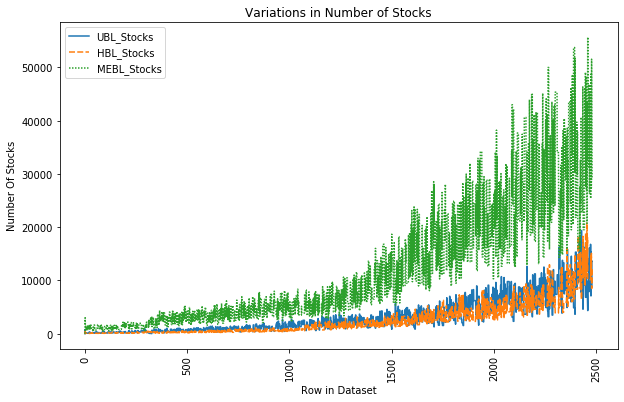

In [40]:
plt.figure(figsize=(10,6))
sns.lineplot(data=d.iloc[:2481,2:5])
plt.xticks(rotation=90)
plt.xlabel('Row in Dataset')
plt.ylabel('Number Of Stocks')
plt.title('Variations in Number of Stocks')
plt.legend(['UBL_Stocks','HBL_Stocks','MEBL_Stocks'],loc='upper left')

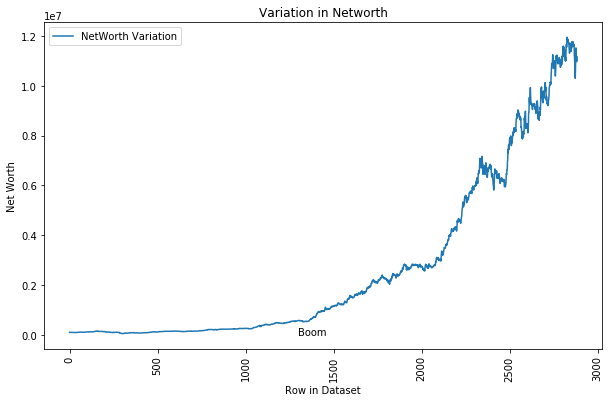

In [41]:
plt.figure(figsize=(10,6))
sns.lineplot(data=d.iloc[:,14])
plt.xticks(rotation=90)
plt.xlabel('Row in Dataset')
plt.ylabel('Net Worth')
plt.title('Variation in Networth')
plt.text(x=1300,y=(.2*(10^7)),s='Boom')
plt.legend(['NetWorth Variation'],loc='upper left')

In [42]:
data3.loc[1450,'Date']

Timestamp('2013-09-19 00:00:00')

# Why 2013 Boom?

### IMF Support relief Programme

![IMF Relief Programme](IMF_PRESS_CUT.png)

### CPEC

![Press Release](CPEC.png)

<IPython.core.display.Javascript object>


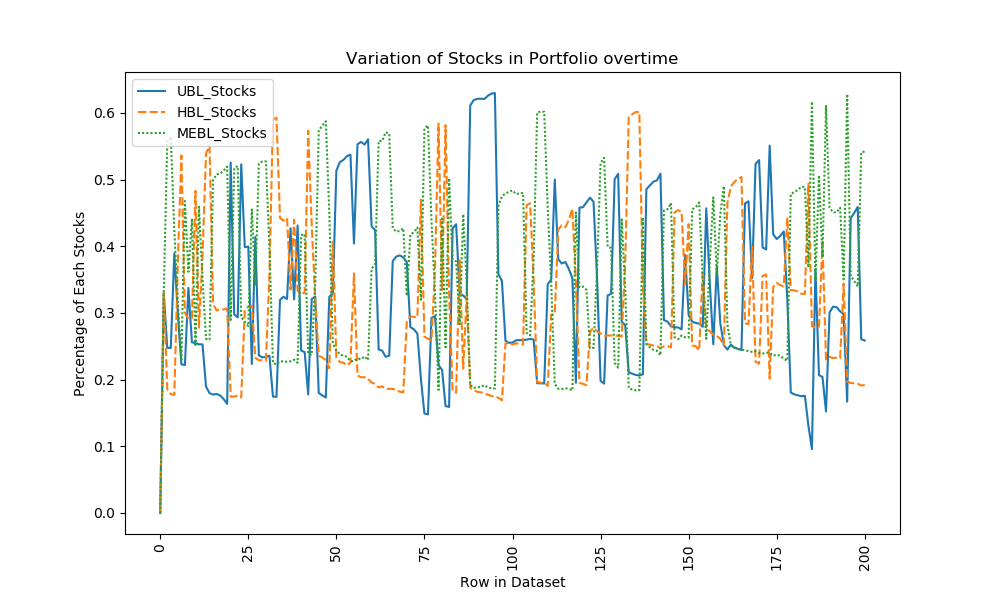

In [245]:
plt.figure(figsize=(10,6))
sns.lineplot(data=d.iloc[:201,11:14])
plt.xticks(rotation=90)
plt.xlabel('Row in Dataset')
plt.ylabel('Percentage of Each Stocks')
plt.title('Variation of Stocks in Portfolio overtime')
plt.legend(['UBL_Stocks','HBL_Stocks','MEBL_Stocks'],loc='upper left')

# Investment Portfolio

In [43]:
total_shares=nS1+nS2+nS3
X,nS1/total_shares,nS2/total_shares,nS3/total_shares

(1000.0000000011642,
 0.13258744659016444,
 0.21397855694849743,
 0.6534339964613382)

# Installing Gradient Boosted Tree model

In [94]:
!pip install XGBoost

In [ ]:
data=df

In [95]:
from sklearn import model_selection,tree
import xgboost as xgb
from sklearn import metrics

In [ ]:
df['date'] = df.index
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
    
X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','Open','High','Low','Volume']]

In [ ]:
X.head()

In [ ]:
X.Open=X.Open.astype('float')
X.High=X.High.astype('float')
X.Low=X.Low.astype('float')
X.Volume=X.Volume.astype('float')

In [ ]:
y=data[['Close']]

In [ ]:
y=y.astype('float')
X

In [ ]:
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.2)

# Training model

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train)

In [ ]:
yhat=reg.predict(X_test)

In [ ]:
#sns.lineplot(data=yhat)
sns.lineplot(data=y_test)

In [ ]:
sns.lineplot(data=yhat)


In [ ]:
metrics.mean_squared_error(y_test,yhat)

In [ ]:
yhat=reg.predict(X_train)

In [ ]:
sns.lineplot(data=yhat)

In [ ]:
sns.lineplot(data=y_test)